# 10 Monkey Species Image Dataset Analysis

Module: CS985 Machine Learning For Data Analytics

Student: Rokas Labeikis

Student ID: 201349799

## Objective and problem

The core problem of the assignment is to create a deep learning model, which classifies images of monkeys into 1 of 10 classes.

The objective is to create an sufficient deep learning classifier which performs well. However, more importantly for the author is to learn and explore machine learning framework Tensorflow. Due to the later reason, more than 1 approach of image classification will be researched and the performance of the models will not be considered a priority.

Explored techniques include:
- Linear image classifier;
- Transfer learning.

## Development environment

In [2]:
# Importing neccesary modules
import warnings
warnings.simplefilter(action='ignore')
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import os
import cv2
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import platform
from __future__ import division
import seaborn as sns
from IPython.display import Image
from sklearn import metrics
from sklearn.metrics import roc_curve
warnings.resetwarnings()

# Versions used
print('TensorFlow version: ', tf.__version__) # 1.7.0
print('Python version: ', platform.python_version()) # 2.7.13

('TensorFlow version: ', '1.7.0')
('Python version: ', '2.7.13')


## Introduction to the dataset

Analyzed dataset was taken from www.kaggle.com and it is called "10 Monkey Species". The original dataset consists of 2 directories ("training" and "validation") and a text file containing all the labels and titles. Each directory  contains 10 subdirectories, labeled from "n0" to "n9" (these labels will be considered as classes). Finally, each subdirectory contains a series of images (images are 400x300 px or larger and they are in JPEG format) of a certain monkey type (class).

Below the contents of the "monkey_labels.txt" file are presented. The table encompasses the overall structure of the dataset.

In [3]:
info = pd.read_csv("input/monkey_labels.txt", names=['Label','Latin Name', 'Common Name','Train Images', 'Validation Images'], skiprows=1)
info

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


## Obtaining and preparing the dataset

In [4]:
# Defining input directory paths
train_dir = 'input/training'
test_dir = 'input/validation'

# label map
map_labels = {'n0': 'mantled_howler',
              'n1': 'patas_monkey',
              'n2': 'bald_uakari',
              'n3': 'japanese_macaque',
              'n4': 'pygmy_marmoset',
              'n5': 'white_headed_capuchin',
              'n6': 'silvery_marmoset',
              'n7': 'common_squirrel_monkey',
              'n8': 'black_headed_night_monkey',
              'n9': 'nilgiri_langur'}

Below "read_data" function is defined. This function takes some directory as an input, then it goes through all of the subdirectories while building the data frame in the process. At the end, it returns a newly constructed data frame and halts. The produced data frame consists of numerical image representation, its label, path to the real image, integer encoded label and one hot encoded label. 

In [5]:
def read_data(filename):
    images = []
    labels = []
    paths = []
    i = 0
    for dir_path in glob.glob(filename + "/*"):
        label = dir_path.split("/")[-1]
        for image_path in glob.glob(os.path.join(dir_path, "*.jpg")):
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            # Adjust stored image size if necessary
            image = cv2.resize(image, (150, 150))
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            
            labels.append(label)
            images.append(image)
            paths.append(image_path)
            
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(labels)
    # one hot binary encode 
    onehot_encoder = OneHotEncoder(sparse=False)
    i_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(i_encoded)
    
    d = {'images':images,'labels':labels, 'path': paths, 'int':integer_encoded, 'hot': onehot_encoded.tolist()}

    df = pd.DataFrame(d)
    return df

train = read_data(train_dir)
test = read_data(test_dir)
# Write data to csv files for possible future use 
train.to_csv('./input/train.csv', index=False) 
test.to_csv('./input/test.csv',  index=False)

Below are a series of checks to make sure everything went smoothly with the input reading and the data frame preparations.

In [6]:
train.head() # first few rows of generated dataframe

,hot,images,int,labels,path
0,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[[241, 244, 249], [239, 242, 248], [242, 245,...",3,n3,input/training/n3/n3049.jpg
1,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[[211, 204, 189], [213, 206, 189], [215, 208,...",3,n3,input/training/n3/n3133.jpg
2,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[[69, 60, 63], [75, 71, 68], [45, 48, 40], [4...",3,n3,input/training/n3/n3170.jpg
3,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[[75, 79, 88], [77, 79, 86], [74, 74, 85], [6...",3,n3,input/training/n3/n3064.jpg
4,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[[191, 204, 220], [185, 198, 214], [178, 191,...",3,n3,input/training/n3/n3135.jpg


In [7]:
train.isnull().sum() # checking for missing values in the dataframe

hot       0
images    0
int       0
labels    0
path      0
dtype: int64

In [8]:
test.isnull().sum()

hot       0
images    0
int       0
labels    0
path      0
dtype: int64

In [9]:
print(train.columns) # making sure column structure is as expected

Index([u'hot', u'images', u'int', u'labels', u'path'], dtype='object')


## Exploring the dataset

There are 1096 images dedicated for model training and 272 for testing. In total there are 1368 number of images.

In [10]:
print(train.shape)
print(test.shape)
print("Total entries: ", len(train)+len(test))

(1096, 5)
(272, 5)
('Total entries: ', 1368)


Random sample of 9 images along with their labels are printed out below. This is done in order to see the type of images we are dealing with and if the labels are matching correctly.

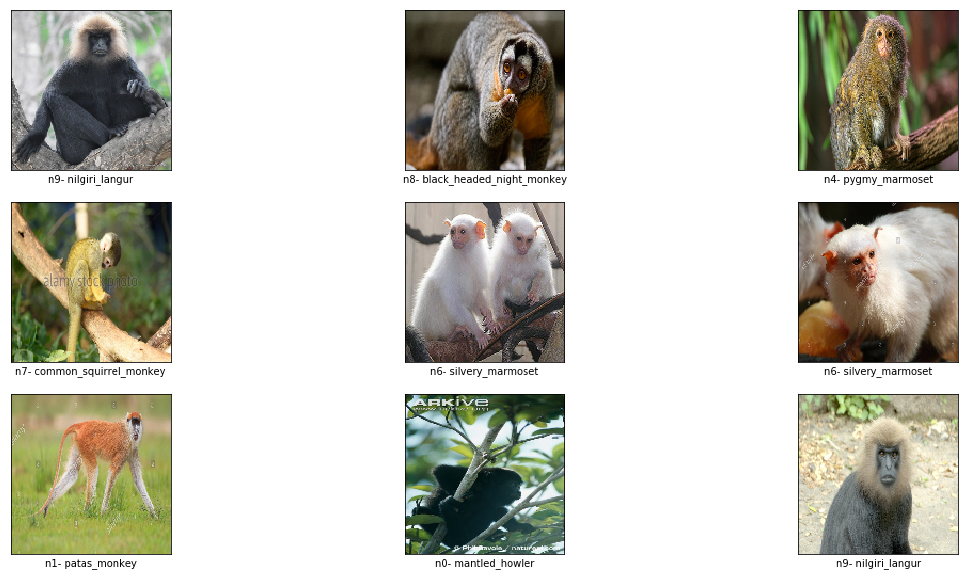

In [11]:
def plot_images(images, labels):
    assert len(images) == len(labels) == 9
    fig = plt.figure(figsize=(20,10))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    for i in range(0,9):
        ax = fig.add_subplot(3, 3, i+1)
        plt.imshow(images.iloc[i])  

        ax.set_xlabel(labels.iloc[i] + '- ' + map_labels[labels.iloc[i]])
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()
    
sample = test.sample(n=9)

# Plot the images and labels using our helper-function above.
plot_images(sample["images"], sample["labels"])


### Data distribution

As we can see the data is roughly evenly distributed, while only the "n3" class has a higher number of entries in both sets, however the difference is not significant so it should have no impact on the results.

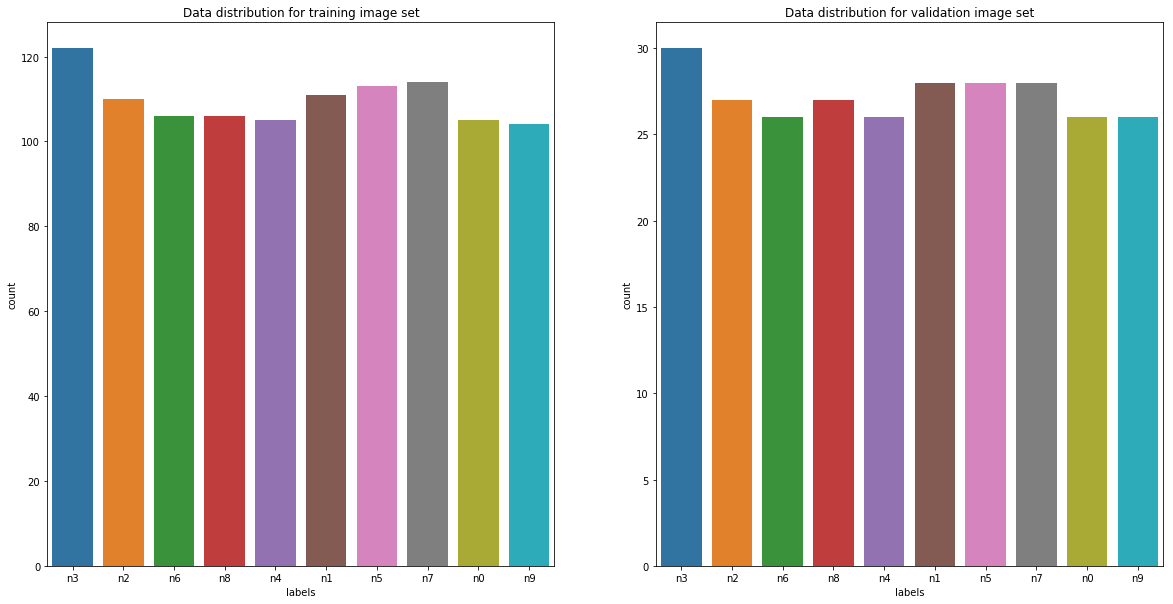

In [12]:
fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax = fig.add_subplot(1, 2, 1)
sns.countplot(train['labels'])
plt.title('Data distribution for training image set')

ax = fig.add_subplot(1, 2, 2)
sns.countplot(test['labels'])
plt.title('Data distribution for validation image set')

plt.show()

## Models

### Transfer learning

Transfer learning is a technique that takes a piece of a model that has already been trained on a related task and reuses it in a creation of a new model. This technique was the first choice for this classification problem because training a completely new model to classify images requires lots of time, processing power and a huge sample size.

In order to train the model, author used a script located in './retrain.py' with following parameters:
- --bottleneck_dir './retrained_model/bottlenecks'
- --output_graph './retrained_model/output_graph.pb'
- --image_dir './input/training'
- --output_labels './retrained_model/output_labels.txt'

Full command (takes around 30 minutes to complete):

```console
python retrain.py  --bottleneck_dir './retrained_model/bottlenecks' --output_graph './retrained_model/output_graph.pb' --image_dir './input/training' --output_labels './retrained_model/output_labels.txt'
```

Below 2 graphs are shown, the first one represents the change of accuracy during the training. And the second one represents constant shifting of the cross entropy while training the model. The graphs were directly taken from TensorFlow Hub.

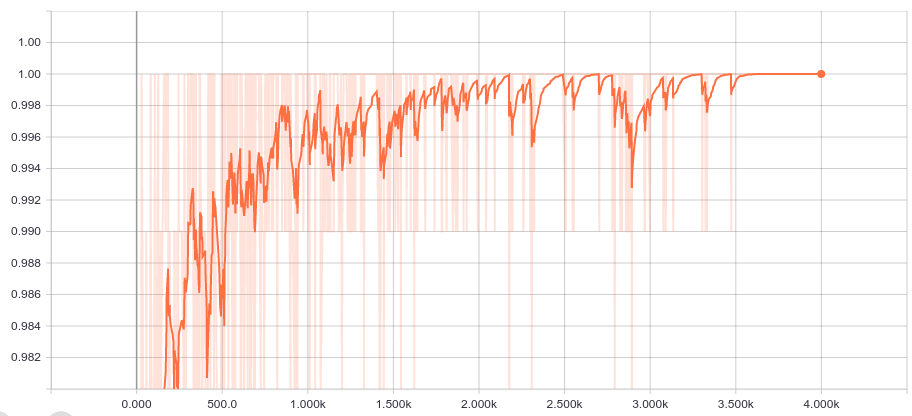

In [13]:
Image("./retrained_model/image_graphs/accuracy.png")

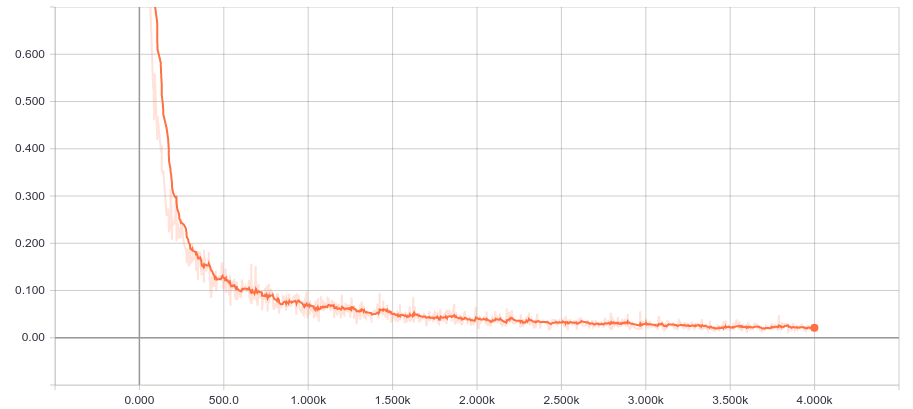

In [14]:
Image("./retrained_model/image_graphs/cross_entropy.png")

#### Transfer learning Validation

In order to properly validate the new classifier, the script below was written. It loads all the labels, loads the newly generated graph, shuffles the testing dataset and runs the classifier on every image in the set.

In [15]:
def load_labels(label_file): # Loading class labels from the file
    label = []
    proto_as_ascii_lines = tf.gfile.GFile(label_file).readlines()
    for l in proto_as_ascii_lines:
        label.append(l.rstrip())
    return label

model_file = 'retrained_model/output_graph.pb'
label_file = 'retrained_model/output_labels.txt'
input_layer = 'Placeholder'
output_layer = 'final_result'

# Load graph
graph = tf.Graph()
graph_def = tf.GraphDef()
with open(model_file, "rb") as f:
    graph_def.ParseFromString(f.read())
with graph.as_default():
    tf.import_graph_def(graph_def)

input_name = "import/" + input_layer
output_name = "import/" + output_layer
input_operation = graph.get_operation_by_name(input_name)
output_operation = graph.get_operation_by_name(output_name)

labels = load_labels(label_file)

# Shuffle test dataframe
test_Tlearning = test.sample(frac=1)
correct = 0  
preds = []    

The loop below runs previously trained model on every image in the validation set, while outputting the confidence level and the classification result after each image.

In [16]:
for index, row in test_Tlearning.iterrows():
    t = row["images"]

    float_caster = tf.cast(t, tf.float32)
    dims_expander = tf.expand_dims(float_caster, 0)
    resized = tf.image.resize_bilinear(dims_expander, [299, 299])
    normalized = tf.divide(tf.subtract(resized, [0]), [255])
    
    sess = tf.Session()
    t = sess.run(normalized)
    
    with tf.Session(graph=graph) as sess:
        results = sess.run(output_operation.outputs[0], {
            input_operation.outputs[0]: t
        })
    results = np.squeeze(results)
    
    top_k = results.argsort()[-1:][::-1]
    for i in top_k:
        preds.append(labels[i])
        if (labels[i] == row["labels"]):
            print(labels[i], results[i], "Correct!")
            correct = correct + 1
        else:
            print(labels[i], results[i], "False! -Correct was: ", row["labels"], " Path: ", row["path"])

('n3', 0.90344673, 'Correct!')
('n3', 0.978212, 'Correct!')
('n5', 0.7513726, 'Correct!')
('n4', 0.97072554, 'Correct!')
('n3', 0.99163264, 'Correct!')
('n7', 0.9862111, 'Correct!')
('n2', 0.9855245, 'Correct!')
('n7', 0.99227, 'Correct!')
('n5', 0.9711689, 'Correct!')
('n7', 0.9880074, 'Correct!')
('n6', 0.96518254, 'Correct!')
('n4', 0.98384315, 'Correct!')
('n3', 0.9962218, 'Correct!')
('n7', 0.92149746, 'Correct!')
('n3', 0.9941415, 'Correct!')
('n1', 0.9924239, 'Correct!')
('n9', 0.9987066, 'Correct!')
('n8', 0.9707032, 'Correct!')
('n2', 0.83481497, 'Correct!')
('n4', 0.96305114, 'Correct!')
('n3', 0.9744708, 'Correct!')
('n0', 0.994269, 'Correct!')
('n3', 0.9987514, 'Correct!')
('n5', 0.9837325, 'Correct!')
('n7', 0.62718266, 'False! -Correct was: ', 'n8', ' Path: ', 'input/validation/n8/n813.jpg')
('n7', 0.6189957, 'False! -Correct was: ', 'n3', ' Path: ', 'input/validation/n3/n3011.jpg')
('n2', 0.9679037, 'Correct!')
('n8', 0.43793216, 'False! -Correct was: ', 'n6', ' Path: ',

('n6', 0.85283846, 'Correct!')
('n8', 0.9943439, 'Correct!')
('n6', 0.9823585, 'Correct!')
('n8', 0.99953413, 'Correct!')
('n1', 0.99805707, 'Correct!')
('n3', 0.99111056, 'Correct!')
('n9', 0.9994666, 'Correct!')
('n3', 0.94546205, 'Correct!')
('n5', 0.99790466, 'Correct!')
('n2', 0.9761656, 'Correct!')
('n0', 0.9733844, 'Correct!')
('n9', 0.9475204, 'Correct!')
('n7', 0.99348444, 'Correct!')
('n5', 0.77374333, 'Correct!')
('n5', 0.9795542, 'Correct!')
('n8', 0.9969427, 'Correct!')
('n0', 0.928805, 'Correct!')
('n9', 0.9753651, 'Correct!')


In [17]:
# Overall accuracy
acc = correct / len(test_Tlearning)
print("Accuracy: ", acc)

('Accuracy: ', 0.9705882352941176)


It is clearly visible that retrained model is performing extremely well- misclassifying only few instances from the validation image set. Furthermore, the accuracy can be improved to be almost 100% if the images were resized into higher resolution, however this was left undone because of performance reasons. Below the evaluation confusion matrix is presented.

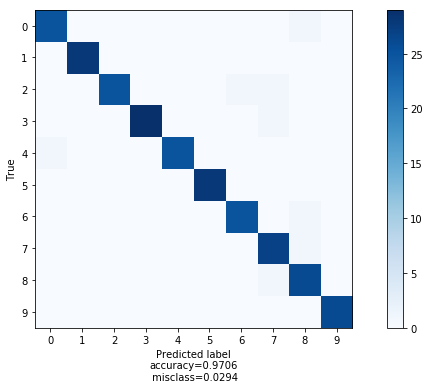

In [18]:
cls_true = test_Tlearning['labels']
    
cls_pred = preds

cm = metrics.confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)
plt.figure(figsize=(10,5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

plt.tight_layout()
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, range(10))
plt.yticks(tick_marks, range(10))
plt.xlabel("Predicted label\naccuracy={:0.4f}\n misclass={:0.4f}".format(acc, 1-acc))
plt.ylabel('True')

plt.show()

## Linear model

A linear classifier uses object's features to identify which class it belongs to by making a classification decision based on the value of a linear combination of the characteristics. Such classifiers work well generally for problems with many features, reaching accuracy levels comparable to non-linear classifiers while taking less time to train and use. Although image classification is typically too complex for a simple linear classifier, the author chose to explore its intricacies as it provided great learning experience because of the variety techniques used.

Below a simple estimator of the linear classifier is defined with expected features (shape included), number of classes and directory of the model.

In [26]:
feature_columns = [tf.feature_column.numeric_column('images', shape=[150,150,3])]

classifier = tf.estimator.LinearClassifier(
    feature_columns=feature_columns,
    n_classes=10,
    model_dir='./linear_model'
)

# image batch size
BATCH_SIZE = 40
TRAIN_STEPS = 2000 # Should be set to at least 2000

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f58511c3150>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': './linear_model', '_save_summary_steps': 100}


Then the function "generate_input_fn()" is defined, it generates an expected "input_fn()" function for training and validating the classifier. This function takes in the "train" or "test" data frame and the batch size. It reads the image data from the passed data frame, shuffles the images and coverts the images and expected labels to tensors. Finally, it returns batches of images and corresponding labels.

In [27]:
def generate_input_fn(df, batch_size):
    def input_fn():
        image_list, label_list = df["images"].tolist(), df["int"].tolist()
        image_list = np.asarray(image_list, np.float32)

        images = tf.convert_to_tensor(image_list, dtype=np.float32)
        labels = tf.convert_to_tensor(label_list, dtype=tf.int32)

        # Shuffle
        shuffled_images, shuffled_labels = tf.train.slice_input_producer([images, labels], shuffle=True)

        image_batch, label_batch = tf.train.batch([shuffled_images, shuffled_labels], batch_size=batch_size)
        return {'images':  image_batch}, label_batch
    return input_fn

Procedure to train the classifier.

In [28]:
classifier.train(
    input_fn=generate_input_fn(train, BATCH_SIZE),
    steps=TRAIN_STEPS
)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./linear_model/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2001 into ./linear_model/model.ckpt.
INFO:tensorflow:loss = 0.0, step = 2001
INFO:tensorflow:global_step/sec: 53.8433
INFO:tensorflow:loss = 0.0, step = 2101 (1.624 sec)
INFO:tensorflow:global_step/sec: 65.1078
INFO:tensorflow:loss = 0.0, step = 2201 (1.479 sec)
INFO:tensorflow:global_step/sec: 67.4636
INFO:tensorflow:loss = 0.0, step = 2301 (1.482 sec)
INFO:tensorflow:global_step/sec: 68.2619
INFO:tensorflow:loss = 0.0, step = 2401 (1.465 sec)
INFO:tensorflow:global_step/sec: 68.2371
INFO:tensorflow:loss = 0.0, step = 2501 (1.465 sec)
INFO:tensorflow:global_step/sec: 68.0707
INFO:tensorflow:loss = 0.0, step = 2601 (1.469 sec)
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 53.2767
INFO:tensorflow:loss = 0.0, step = 10501 (1.876 sec)
INFO:tensorflow:global_step/sec: 59.9314
INFO:tensorflow:loss = 0.0, step = 10601 (1.669 sec)
INFO:tensorflow:global_step/sec: 49.3625
INFO:tensorflow:loss = 0.0, step = 10701 (2.027 sec)
INFO:tensorflow:global_step/sec: 38.6219
INFO:tensorflow:loss = 0.0, step = 10801 (2.590 sec)
INFO:tensorflow:global_step/sec: 54.527
INFO:tensorflow:loss = 0.0, step = 10901 (1.832 sec)
INFO:tensorflow:global_step/sec: 58.8298
INFO:tensorflow:loss = 0.0, step = 11001 (1.700 sec)
INFO:tensorflow:global_step/sec: 47.4757
INFO:tensorflow:loss = 0.0, step = 11101 (2.107 sec)
INFO:tensorflow:global_step/sec: 38.9545
INFO:tensorflow:loss = 0.0, step = 11201 (2.567 sec)
INFO:tensorflow:global_step/sec: 57.0619
INFO:tensorflow:loss = 0.0, step = 11301 (1.752 sec)
INFO:tensorflow:global_step/sec: 59.771
INFO:tensorflow:loss = 0.0, step = 11401 (1.673 sec)
INFO:tensorflow:global_step/sec: 46.8204
INFO:tensorflow:loss 

#### Linear classifier validation

As expected linear classifier performed very poorly, averaging around 55% accuracy, however it still performs better than random guessing. Also, the performance of the model may further be improved by adjusting the options.

In [29]:
evaluation_scores = classifier.evaluate(
    input_fn=generate_input_fn(test, BATCH_SIZE),
    steps=100
)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-20-16:52:52
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./linear_model/model.ckpt-12000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Evaluation [40/100]
INFO:tensorflow:Evaluation [50/100]
INFO:tensorflow:Evaluation [60/100]
INFO:tensorflow:Evaluation [70/100]
INFO:tensorflow:Evaluation [80/100]
INFO:tensorflow:Evaluation [90/100]
INFO:tensorflow:Evaluation [100/100]
INFO:tensorflow:Finished evaluation at 2018-04-20-16:52:54
INFO:tensorflow:Saving dict for global step 12000: accuracy = 0.5665, average_loss = 14274.221, global_step = 12000, loss = 570968.8


## Evaluation

A brief accuracy comparison between the examined models and a random classification model. Given that there are 10 classes and the test image set has almost even class distribution, assumption was made that the random classifier has 10% accuracy.

Average accuracy scores:
Random Classifier: 0.1
LinearClassifier: 0.5665
RetrainedModel: 0.970588235294


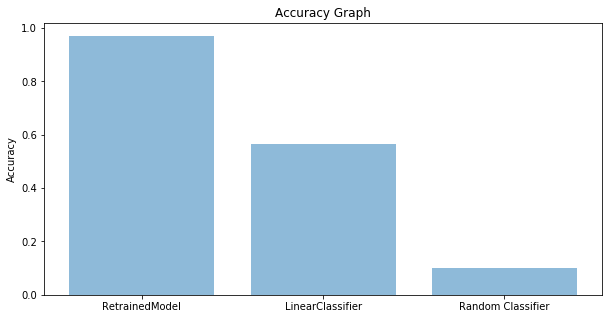

In [25]:
results = [acc, evaluation_scores['accuracy'], 0.1]
names = ['RetrainedModel', 'LinearClassifier', 'Random Classifier']
fig = plt.figure(figsize=(10,5))

print("Average accuracy scores:")
print("Random Classifier: 0.1")
print('LinearClassifier: ' + str(evaluation_scores['accuracy']))    
print('RetrainedModel: ' + str(acc))

y_pos = np.arange(len(results))
plt.bar(y_pos, results, align='center', alpha=0.5)
plt.xticks(y_pos, names)
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')

plt.show()

## Conclusion 

To summarize, the 10 Monkey Species image dataset was examined in order to solve the 10 way classification problem - deducing to which class does a given image belong to. While analyzing the dataset the author had to deal with various new challenges, such as importing images, preprocessing (reshaping, rescaling etc) images, transforming data to tensors, as well as, preparing, training and validating the TensorFlow classifiers.

First set was importing and preparing the data, thus, new data frame was created for each, training and testing image sets. These data frames were used to assist further image dataset analysis. The data frame features were:

- Image paths;
- Image representations (array);
- Image labels;
- Image integer encoded labels;
- Image one hot encoded labels.

Moreover, few different image classifiers were implemented and their accuracy scores were compared.The retrained model classifier, as expected, had an edge over linear classifier with an average accuracy score of more than 97%. While linear classifier was accurate only around 55% of the time.

Finally, this project was a valuable learning experience for the author, who learned how to cope with TensorFlow data manipulation, visualization, and analysis techniques. The issue of discovering the most appropriate methods for image dataset analysis, for example, proved to be both engaging and challenging. Along with the latter insights, the author also had an opportunity to improve Python coding principles.